<a href="https://colab.research.google.com/github/NadiaFinzi/diplodatos-deep-learning/blob/main/Informe_final_ML_Challange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Deep Learning
## **"ML Challenge - Informe".**

### Integrantes

- Tejerina, Maximiliano
- Gutierrez, Denise
- Finzi, Nadia
- Gherra C., Estefanía Inés
- Primo, Eugenia

# Introducción
El presente notebook muestra el trabajo realizado de forma secuencial. Sin embargo, se aclara que se procesaron los datos con Nabucodonosor (se deja el archivo en el repositorio con nombre [COMPLETAR]) y se hizo un seguimiento de las métricas obtenidas variando ciertos hiperparámetros utilizando la aplicación MLflow (se adjunta la carpeta con las pruebas correspondientes con nombre [COMPLETAR] en el mismo repositorio, y se muestran los 3 mejores resultados obtenidos al final de este documento).

# Bibliotecas

In [ ]:
import gzip
import mlflow
import json
from sklearn.metrics import balanced_accuracy_score

import numpy
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torchvision
#import torchvision.transforms as transforms
import tempfile
from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Ensure version 4.X
import gensim
gensim.__version__

'4.1.2'

## Definiciones para la prepraración de los datos

In [ ]:
from torch.utils.data import IterableDataset


class MeLiChallenge(IterableDataset):
    def __init__(self, dataset_path, random_buffer_size=2048):
        assert random_buffer_size > 0
        self.dataset_path = dataset_path
        self.random_buffer_size = random_buffer_size

        with gzip.open(self.dataset_path, 'rt') as dataset:
            item = json.loads(next(dataset).strip())
            self.dataset_size = item['size']
            self.labels_count = item['n_labels']

    def __len__(self):
        return self.dataset_size

    def __iter__(self):
        try:
            with gzip.open(self.dataset_path, 'rt') as dataset:
                shuffle_buffer = []

                for line in dataset:
                    item = json.loads(line.strip())
                    item = {'data': item['data'], 'target': item['target']}

                    if self.random_buffer_size == 1:
                        # Let's be honest, this is not random!
                        yield item
                    else:
                        shuffle_buffer.append(item)

                        if len(shuffle_buffer) == self.random_buffer_size:
                            # Fill the buffer and then suffle
                            random.shuffle(shuffle_buffer)
                            for item in shuffle_buffer:
                                yield item
                            shuffle_buffer = []

                if len(shuffle_buffer) > 0:
                    # We have some remainder...
                    random.shuffle(shuffle_buffer)
                    for item in shuffle_buffer:
                        yield item

        except GeneratorExit:
            return


class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data = [item["data"] for item in items]
        target = [item["target"] for item in items]
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]

        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }


# Fundamentación y definición del modelo
Inicialmente probamos con un modelo RNN. Sin embargo, obtuvimos métricas no satisfactorias. Luego probamos con varios modelos CNN, en los cuales cambiábamos los hiperparámetros. 

Llegamos a la conclusión que, efectivamente, la RNN no nos estaba dando buenos resultados para nuestro tipo de problema, porque suelen ser más adecuados para aprender patrones a través del tiempo, de datos que tienen internamente una secuencia. Mientras que entendemos que la red CNN arrojó mejores métricas ya que suelen ser más apropiadas para aprender patrones de características distribuidas en un espacio/momento/set de datos; en este caso, serían las características de un conjunto de productos.

En particular, observamos que con una mayor cantidad de épocas la red aprendió mejor, la tasa de error bajó y nos conformó el accuracy.



In [ ]:

class CNNClassifier(nn.Module):
    def __init__(self,
                 pretrained_embeddings,
                 token_to_index,
                 labels_count,
                 vector_size=300,
                 freeze_embedings=True,
                 hidden_layers=[256, 128],
                 dropout=0.3,
                 batch_size=128):
        super().__init__()
        with gzip.open(token_to_index, 'rt') as fh:
            token_to_index = json.load(fh)
        embeddings_matrix = torch.randn(len(token_to_index), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with gzip.open(pretrained_embeddings, 'rt') as fh:
            # Let's fill the embedding matrix
            next(fh)
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in token_to_index:
                    wordID = token_to_index[word]
                    embeddings_matrix[wordID] = torch.FloatTensor([float(n) for n in vector.split()])
        # Embedding Layer
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        # Convolutional Layers
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                    nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght)
                    )
        self.convs = nn.ModuleList(self.convs)
        
        # Linear Layers
        self.hidden_layers = [
            nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), hidden_layers[0])
        ]
        for input_size, output_size in zip(hidden_layers[:-1], hidden_layers[1:]):
            self.hidden_layers.append(
                nn.Linear(input_size, output_size)
            )
        self.dropout = dropout
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.output = nn.Linear(hidden_layers[-1], labels_count)
        self.vector_size = vector_size
        

    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])

    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2) 
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            if self.dropout:
                x = F.dropout(x, self.dropout)
        x = self.output(x)
        return x


In [ ]:
ls data/meli-challange-2019/

SBW-vectors-300-min5.bin.gz     portuguese_token_to_index.json.gz
SBW-vectors-300-min5.txt.bz2    spanish.test.jsonl.gz
portuguese.test.jsonl.gz        spanish.train.jsonl.gz
portuguese.train.jsonl.gz       spanish.validation.jsonl.gz
portuguese.validation.jsonl.gz  spanish_token_to_index.json.gz


In [ ]:
ls data/

glove.6B.50d.txt.gz  imdb_reviews.csv.gz  meli-challange-2019@


# Carga de datasets

## Train

In [ ]:

train_dataset = MeLiChallenge(
    dataset_path="./data/meli-challange-2019/spanish.train.jsonl.gz",
    random_buffer_size=400
)

In [ ]:
labels_count=train_dataset.labels_count,
labels_count

(632,)

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 2048

pad_sequences = PadSequences(
    pad_value=0,
    max_length=None,
    min_length=1
)

train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=pad_sequences,
        drop_last=False
    )



## Test

In [ ]:
test_dataset = MeLiChallenge(
    dataset_path="./data/meli-challange-2019/spanish.test.jsonl.gz",
    random_buffer_size=1
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
   shuffle=False,
    collate_fn=pad_sequences,
    drop_last=False
)

## Validation

In [ ]:
validation_dataset = MeLiChallenge(
    dataset_path="./data/meli-challange-2019/spanish.validation.jsonl.gz",
    random_buffer_size=1
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_sequences,
    drop_last=False
)


# Resultados de las 3 variaciones del modelo seleccionadas


A continuación mostramos los 3 resultados más satisfactorios de las 23 corridas realizadas.

Para los 3 modelos que mostramos utilizamos:
* random_buffer_size = 512
* fc_size = 128
* vector_size = 50
* batch_size = 600

En cada modelo se especifican los hiperparámetros que modificamos.

## Modelo 1

Hiperparámetros seleccionados para este modelo:

* EPOCHS = 2
* FILTERS_COUNT = 100
* FILTERS_LENGTH = [2, 3, 4]
* LR= 1e-5
* WD=1e-4



In [ ]:
import random
mlflow.set_experiment(f'Diplomatura')

EPOCHS = 2
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]
LR= 1e-5
WD=1e-4

with mlflow.start_run():
    #Start experiment
    # Log all relevent hyperparameters
    mlflow.log_params({
        'model_type': 'CNN network',
        'learning_rate': LR,
        'weight_decay': WD,
        'random_buffer_size': 512,
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    
    })
    # Look for the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Building classifier
    model = CNNClassifier(
            labels_count=train_dataset.labels_count,
            token_to_index='./data/meli-challange-2019/spanish_token_to_index.json.gz',
            pretrained_embeddings="./data/glove.6B.50d.txt.gz",
            vector_size=50,
            freeze_embedings=True,
            batch_size=600,
            )
    # Send the model to the device
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        weight_decay=WD,
        lr=LR
    )

    # Training classifier
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = [] 
        targets = []
        predictions = []
       
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(data)
            loss_value = loss(output, target)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
            targets.extend(batch['target'].numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
        mlflow.log_metric('train_loss', sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('train_bacc', balanced_accuracy_score(targets, predictions), epoch)

        #'Evaluating model on validation'
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        with torch.no_grad():
            for batch in tqdm(validation_loader):
                data = batch['data'].to(device)
                target = batch['target'].to(device)
                output = model(data)
                loss_value = loss(output, target)
                running_loss.append(loss_value.item())
                targets.extend(batch['target'].numpy())
                predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            mlflow.log_metric('validation_loss', sum(running_loss) / len(running_loss), epoch)
            mlflow.log_metric('validation_bacc', balanced_accuracy_score(targets, predictions), epoch)

    #Evaluating model on test
    model.eval()
    running_loss = []
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(data)
            loss_value = loss(output, target)
            running_loss.append(loss_value.item())
            targets.extend(batch['target'].numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
        mlflow.log_metric('test_loss', sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('test_bacc', balanced_accuracy_score(targets, predictions), epoch)



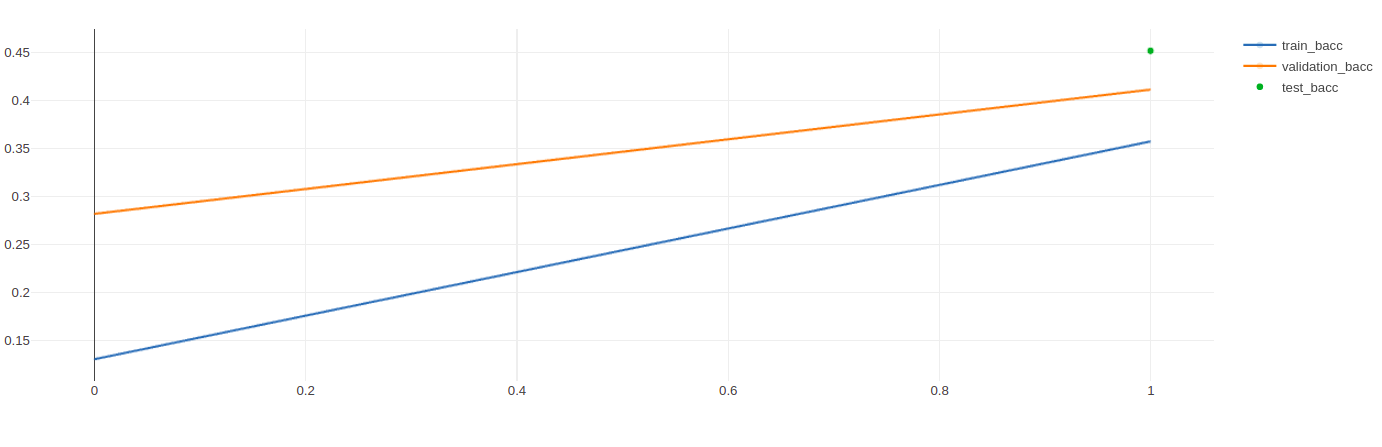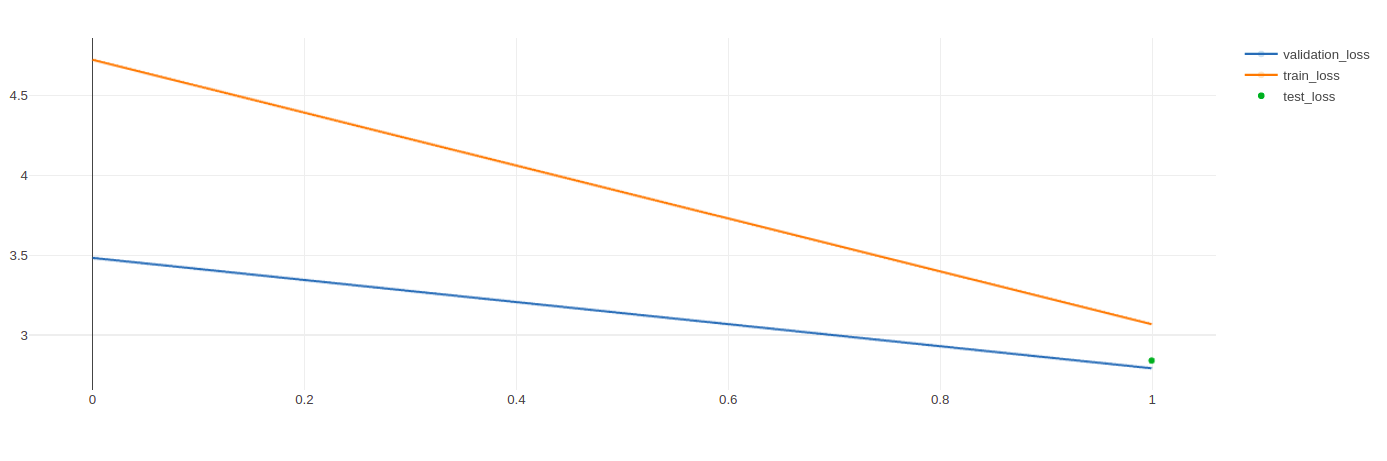

### Métricas obtenidas

*Loss:*
* train_loss: 3.068
* test_loss: 2.84
* validation_loss: 2.792

*Accuracy:*
* train_bacc: 0.358
* test_bacc: 0.452
* validation_bacc: 0.412



## Modelo 2

Hiperparámetros seleccionados para este modelo:

* EPOCHS = 15
* FILTERS_COUNT = 150
* FILTERS_LENGTH = [4, 5, 7]
* LR= 1e-6
* WD=1e-7



In [ ]:
import random
mlflow.set_experiment(f'Diplomatura')

EPOCHS = 15
FILTERS_COUNT = 150
FILTERS_LENGTH = [4, 5, 7]
LR= 1e-6
WD=1e-7

with mlflow.start_run():
    #Start experiment
    # Log all relevent hyperparameters
    mlflow.log_params({
        'model_type': 'CNN network',
        'learning_rate': LR,
        'weight_decay': WD,
        'random_buffer_size': 512,
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    
    })
    # Look for the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Building classifier
    model = CNNClassifier(
            labels_count=train_dataset.labels_count,
            token_to_index='./data/meli-challange-2019/spanish_token_to_index.json.gz',
            pretrained_embeddings="./data/glove.6B.50d.txt.gz",
            vector_size=50,
            freeze_embedings=True,
            batch_size=600,
            )
    # Send the model to the device
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        weight_decay=WD,
        lr=LR
    )

    # Training classifier
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = [] 
        targets = []
        predictions = []
       
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(data)
            loss_value = loss(output, target)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
            targets.extend(batch['target'].numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
        mlflow.log_metric('train_loss', sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('train_bacc', balanced_accuracy_score(targets, predictions), epoch)

        #'Evaluating model on validation'
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        with torch.no_grad():
            for batch in tqdm(validation_loader):
                data = batch['data'].to(device)
                target = batch['target'].to(device)
                output = model(data)
                loss_value = loss(output, target)
                running_loss.append(loss_value.item())
                targets.extend(batch['target'].numpy())
                predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            mlflow.log_metric('validation_loss', sum(running_loss) / len(running_loss), epoch)
            mlflow.log_metric('validation_bacc', balanced_accuracy_score(targets, predictions), epoch)

    #Evaluating model on test
    model.eval()
    running_loss = []
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(data)
            loss_value = loss(output, target)
            running_loss.append(loss_value.item())
            targets.extend(batch['target'].numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
        mlflow.log_metric('test_loss', sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('test_bacc', balanced_accuracy_score(targets, predictions), epoch)



  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

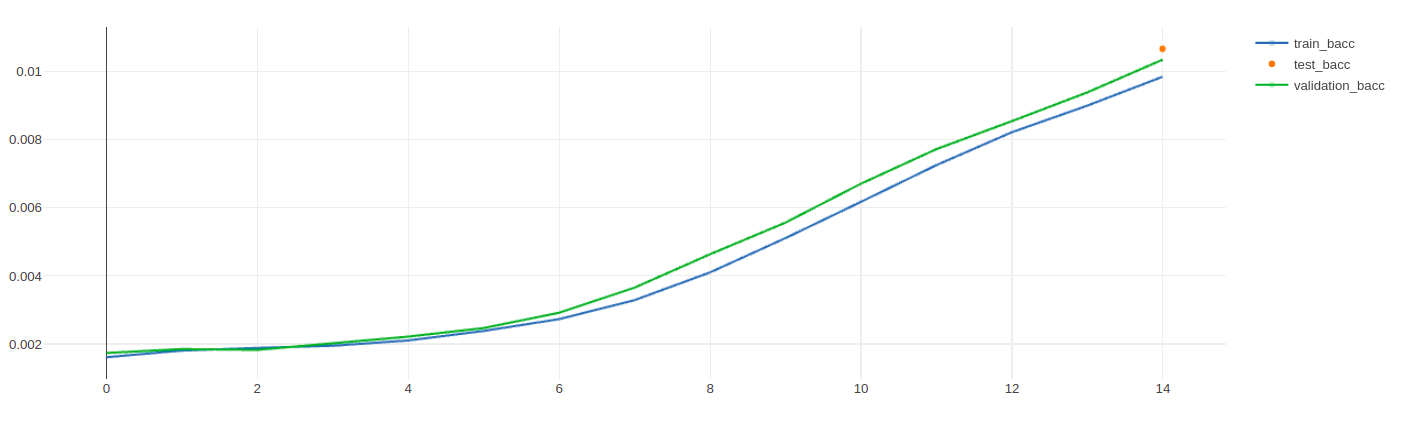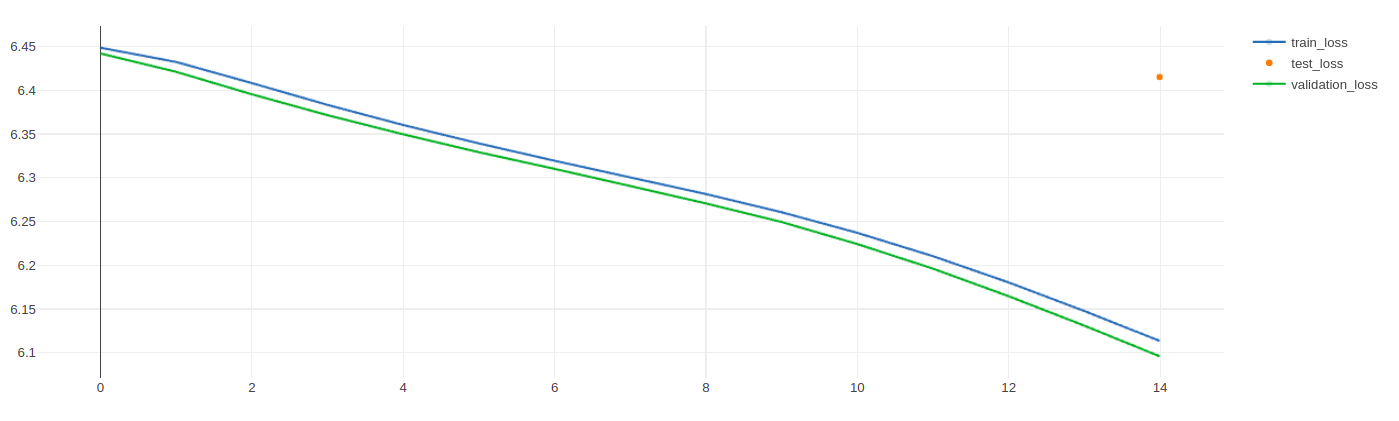

### Métricas obtenidas

*Loss:*
* train_loss: 6.114
* test_loss: 6.415
* validation_loss: 6.096

*Accuracy:*
* train_bacc: 0.01
* test_bacc: 0.011
* validation_bacc: 0.01



## Modelo 3

Hiperparámetros seleccionados para este modelo:

* EPOCHS = 30
* FILTERS_COUNT = 200
* FILTERS_LENGTH = [4, 6, 8]
* LR= 1e-3
* WD=1e-4



In [ ]:
import random
mlflow.set_experiment(f'Diplomatura')

EPOCHS = 30
FILTERS_COUNT = 200
FILTERS_LENGTH = [4, 6, 8]
LR= 1e-3
WD=1e-4

with mlflow.start_run():
    #Start experiment
    # Log all relevent hyperparameters
    mlflow.log_params({
        'model_type': 'CNN network',
        'learning_rate': LR,
        'weight_decay': WD,
        'random_buffer_size': 512,
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    
    })
    # Look for the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Building classifier
    model = CNNClassifier(
            labels_count=train_dataset.labels_count,
            token_to_index='./data/meli-challange-2019/spanish_token_to_index.json.gz',
            pretrained_embeddings="./data/glove.6B.50d.txt.gz",
            vector_size=50,
            freeze_embedings=True,
            batch_size=600,
            )
    # Send the model to the device
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        weight_decay=WD,
        lr=LR
    )

    # Training classifier
    for epoch in trange(EPOCHS):
        model.train()
        running_loss = [] 
        targets = []
        predictions = []
       
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(data)
            loss_value = loss(output, target)
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
            targets.extend(batch['target'].numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
        mlflow.log_metric('train_loss', sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('train_bacc', balanced_accuracy_score(targets, predictions), epoch)

        #'Evaluating model on validation'
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        with torch.no_grad():
            for batch in tqdm(validation_loader):
                data = batch['data'].to(device)
                target = batch['target'].to(device)
                output = model(data)
                loss_value = loss(output, target)
                running_loss.append(loss_value.item())
                targets.extend(batch['target'].numpy())
                predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
            mlflow.log_metric('validation_loss', sum(running_loss) / len(running_loss), epoch)
            mlflow.log_metric('validation_bacc', balanced_accuracy_score(targets, predictions), epoch)

    #Evaluating model on test
    model.eval()
    running_loss = []
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            data = batch['data'].to(device)
            target = batch['target'].to(device)
            output = model(data)
            loss_value = loss(output, target)
            running_loss.append(loss_value.item())
            targets.extend(batch['target'].numpy())
            predictions.extend(output.argmax(axis=1).detach().cpu().numpy())
        mlflow.log_metric('test_loss', sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('test_bacc', balanced_accuracy_score(targets, predictions), epoch)



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/2391 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

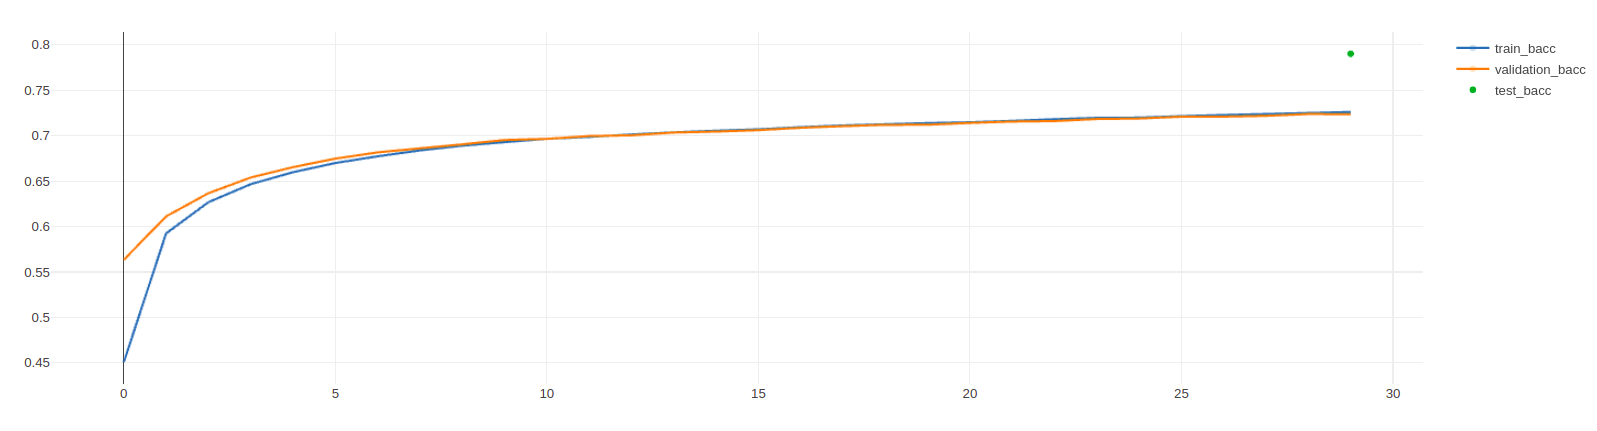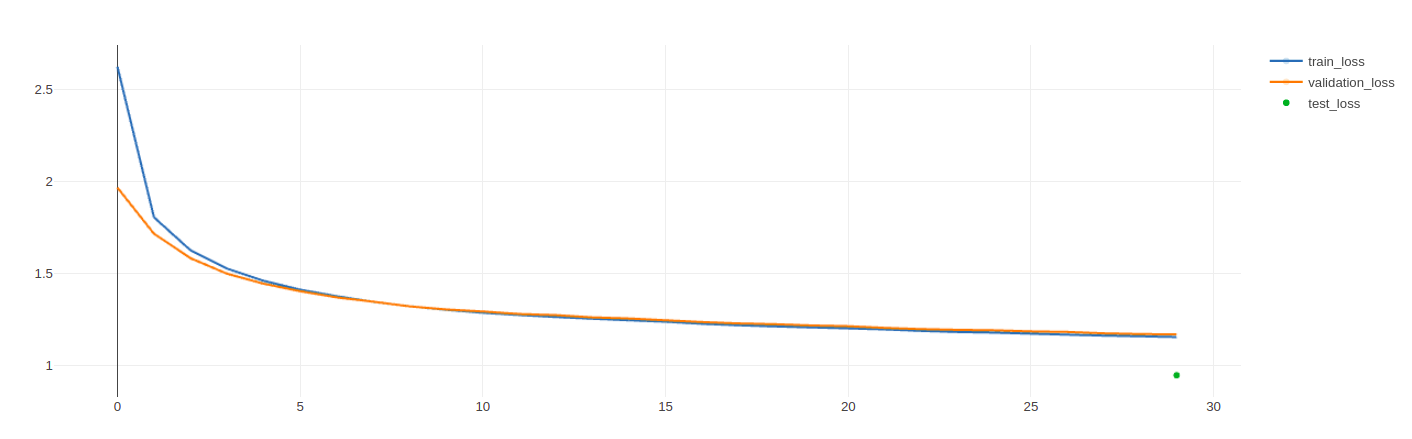

### Métricas obtenidas

*Loss:*
* train_loss: 1.156
* test_loss: 0.949
* validation_loss: 1.17

*Accuracy:*
* train_bacc: 0.726
* test_bacc: 0.79
* validation_bacc: 0.724



# Conclusión final

Al comparar los tres modelos vemos que el **tercero** alcanza mejores métricas de *accuracy* (*0.79*, la más alta) y *loss* (*0.949*, la más baja).

Creemos que las mejoras pueden deberse a una mayor cantidad de *épocas* (30), combinada con una *tasa de aprendizaje* (1e-3) y una *weight_decay* (1e-4) más altas, en relación a los otros dos modelos.

Comparando los gráficos, vemos que las pendientes de las curvas de loss (bajando) y de accuracy (subiendo) en los primeros dos modelos son más pronunciadas, mientras que en el tercero se achatan o llegan a una especie de saturación, interpretando así que llegamos a una cantidad de épocas óptima, luego de la cual el modelo no aprendería mucho más.

A su vez, concluimos que en el tercer modelo la mejora en las métricas obtenida se consiguió aumentando la tasa de aprendizaje, sin caer en el problema de la divergencia.